In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

In [2]:
# Loading the dataset
combined_df = pd.read_csv('updated_combined_data.csv')

In [ ]:
# Handle null values
combined_df['text'].fillna('', inplace=True)
combined_df.dropna(subset=['label'], inplace=True)

In [4]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# preprocessing the data like converting all alphabets to lowercase, removing url and non-alphabetic characters, removing common english stop words and lemmatization
def preprocess(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+|[^a-zA-Z\s]', '', text, re.I|re.A)
    words = [word for word in text.split() if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Apply preprocessing to the text column
combined_df['text'] = combined_df['text'].apply(preprocess)

In [5]:
# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(combined_df['text'])
y = combined_df['label']

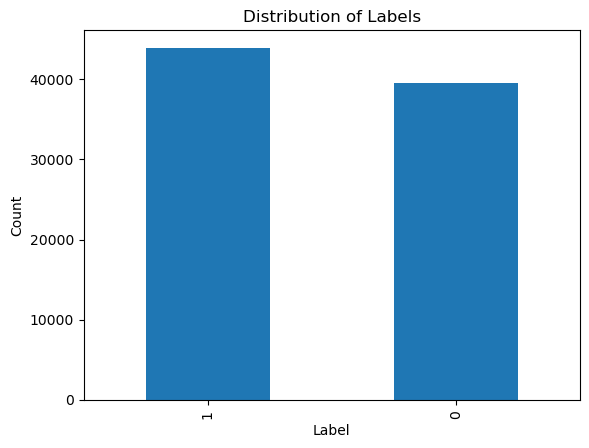

In [6]:
# a bar plot to show the preprocesses data
combined_df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [7]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [8]:
# Train LightGBM model
train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'binary_logloss',
    'learning_rate': 0.1,
    'num_leaves': 31
}
lgb_model = lgb.train(params, train_data, num_boost_round=100)
y_pred_lgb = lgb_model.predict(X_test)
y_pred_lgb = np.where(y_pred_lgb > 0.5, 1, 0)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb)
recall_lgb = recall_score(y_test, y_pred_lgb)
f1_lgb = f1_score(y_test, y_pred_lgb)

[LightGBM] [Info] Number of positive: 26361, number of negative: 23722
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.719682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669512
[LightGBM] [Info] Number of data points in the train set: 50083, number of used features: 4978
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526346 -> initscore=0.105483
[LightGBM] [Info] Start training from score 0.105483


In [9]:
# Train and evaluate Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

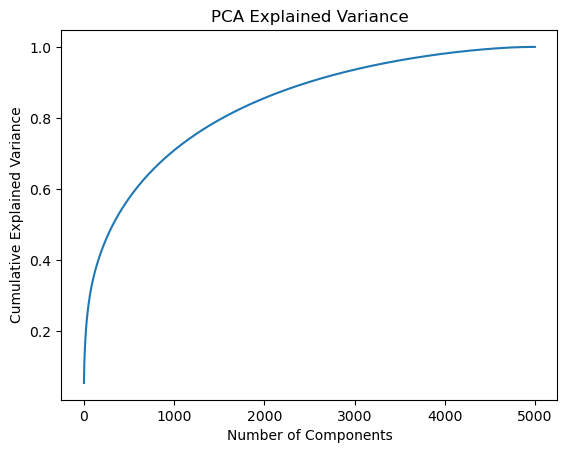

In [10]:
# Apply PCA to reduce the number of features
pca = PCA(n_components=100)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train.toarray())
X_test_pca = pca.transform(X_test.toarray())

pca = PCA().fit(X_train.toarray())
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

In [11]:
# Train and evaluate KNN with reduced dimensions
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_pca, y_train)
y_pred_knn = knn_model.predict(X_test_pca)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

In [12]:
# Compare performance metrics
results = {
    'Model': ['LightGBM', 'Random Forest', 'KNN'],
    'Accuracy': [accuracy_lgb, accuracy_rf, accuracy_knn],
    'Precision': [precision_lgb, precision_rf, precision_knn],
    'Recall': [recall_lgb, recall_rf, recall_knn],
    'F1 Score': [f1_lgb, f1_rf, f1_knn]
}
results_df = pd.DataFrame(results)
print(results_df)

           Model  Accuracy  Precision    Recall  F1 Score
0       LightGBM  0.978796   0.971101  0.989356  0.980144
1  Random Forest  0.983468   0.983170  0.985619  0.984393
2            KNN  0.975322   0.970914  0.982788  0.976815


In [13]:
# Save the LightGBM model and vectorizer
with open('lgb_model.pkl', 'wb') as model_file:
    pickle.dump(lgb_model, model_file)

with open('tfidf_vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(vectorizer, vec_file)

# Get predictions on the validation set
y_val_pred = lgb_model.predict(X_val)

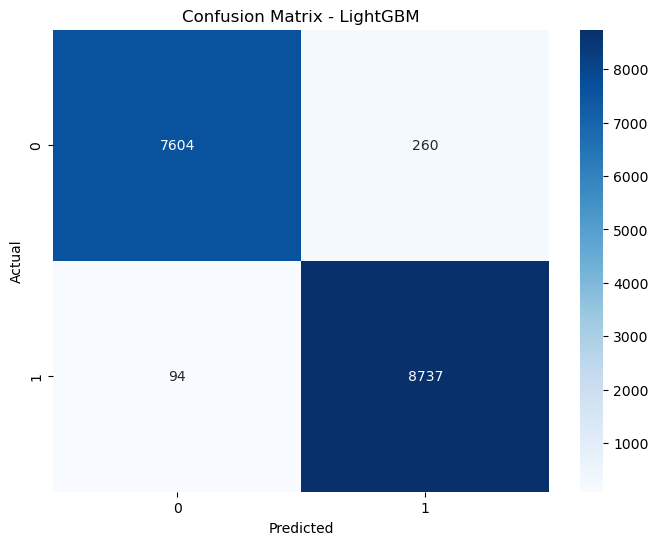

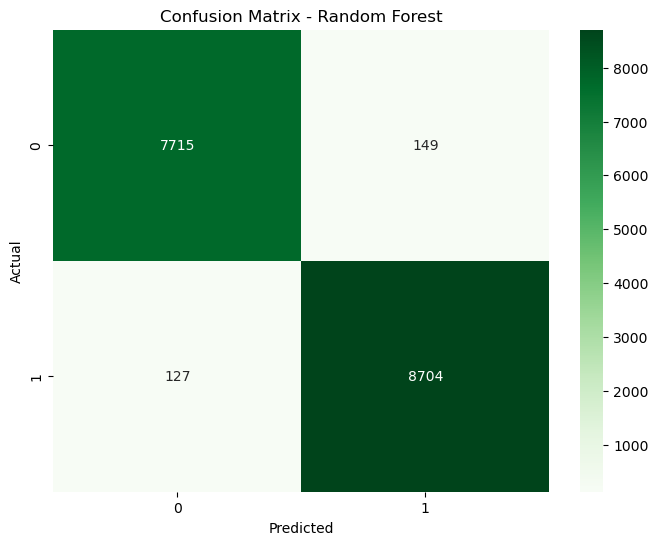

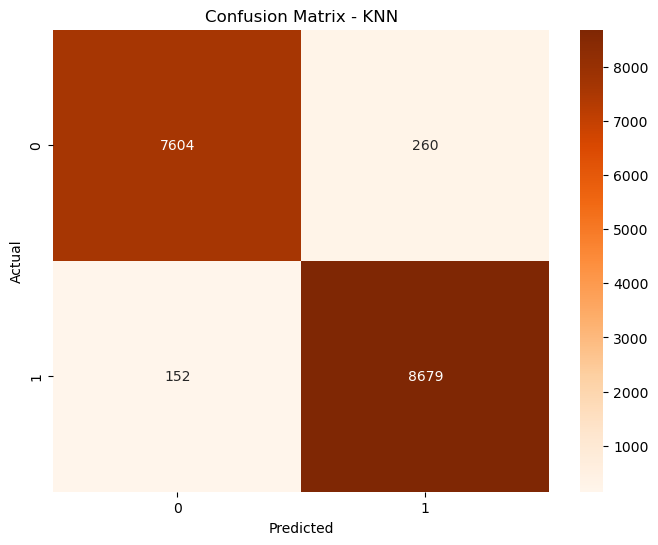

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix for LightGBM
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LightGBM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

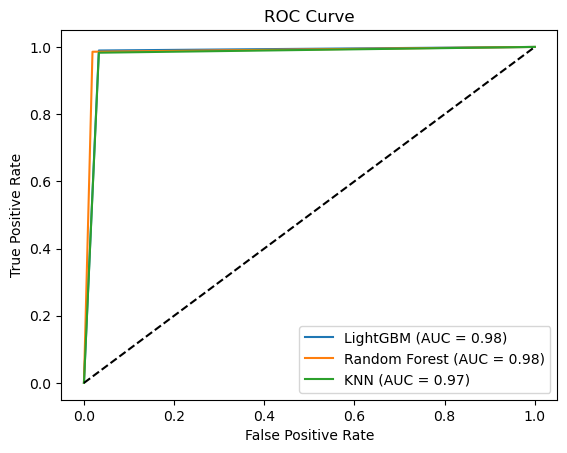

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score

# ROC curve for LightGBM
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_lgb)
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {roc_auc_score(y_test, y_pred_lgb):.2f})')

# ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_rf):.2f})')

# ROC curve for KNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_score(y_test, y_pred_knn):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

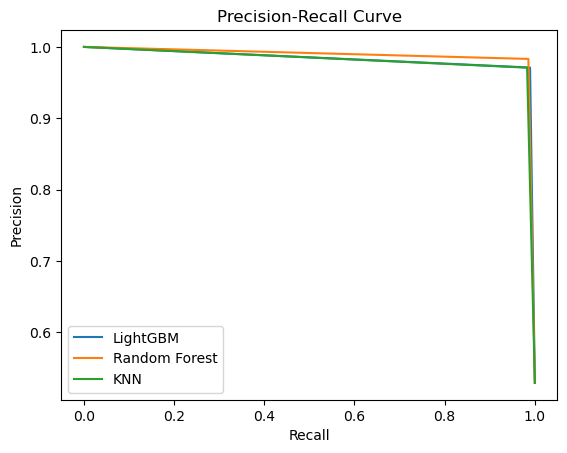

In [16]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall curve for LightGBM
precision_lgb, recall_lgb, _ = precision_recall_curve(y_test, y_pred_lgb)
plt.plot(recall_lgb, precision_lgb, label='LightGBM')

# Precision-Recall curve for Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf)
plt.plot(recall_rf, precision_rf, label='Random Forest')

# Precision-Recall curve for KNN
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_pred_knn)
plt.plot(recall_knn, precision_knn, label='KNN')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

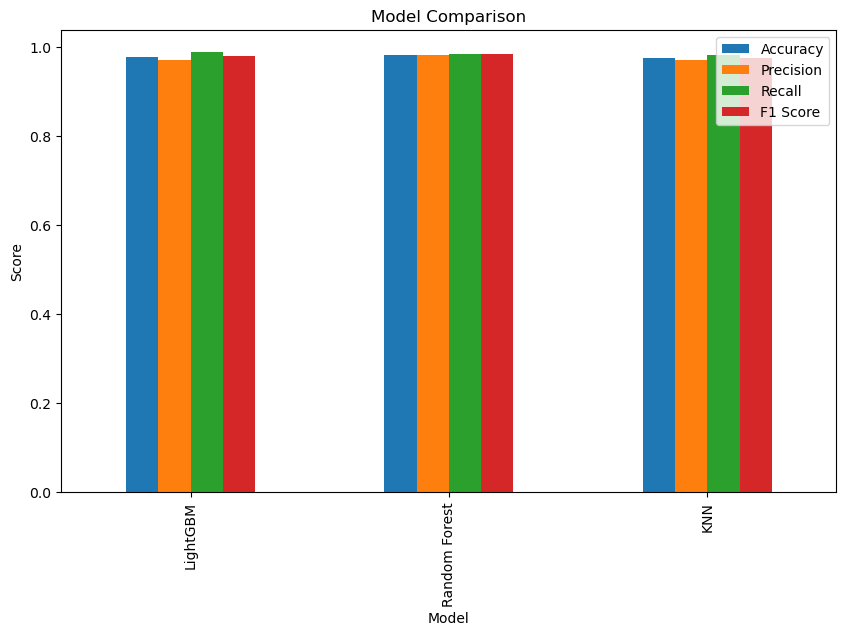

In [17]:
# Model comparison bar plot
results_df.plot(x='Model', kind='bar', figsize=(10, 6), legend=True)
plt.title('Model Comparison')
plt.ylabel('Score')
plt.show()

   ---------------------------------------- 0.0/301.4 kB ? eta -:--:--
   - -------------------------------------- 10.2/301.4 kB ? eta -:--:--
   --- ----------------------------------- 30.7/301.4 kB 330.3 kB/s eta 0:00:01
   --------- ----------------------------- 71.7/301.4 kB 563.7 kB/s eta 0:00:01
   ---------------------------------------  297.0/301.4 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 301.4/301.4 kB 1.7 MB/s eta 0:00:00


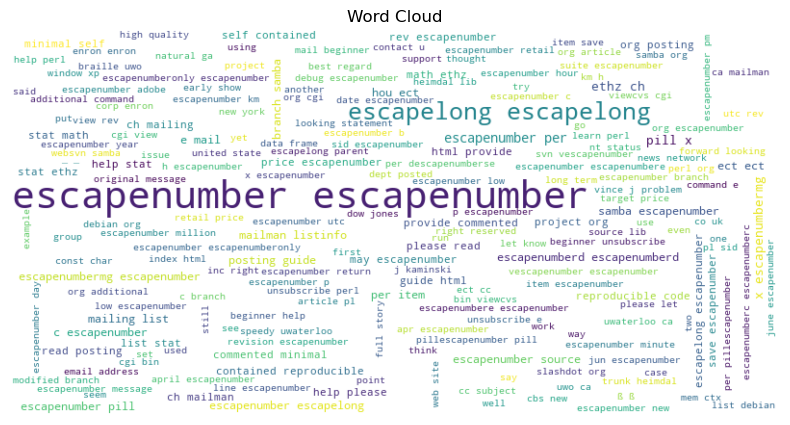

In [19]:
!pip install wordcloud
from wordcloud import WordCloud

text = ' '.join(combined_df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()